# Trabajo Práctico 1: Análisis exploratorio del dataset de Navent
#### Grupo:
- Iglesias, Matias
- Liberali, Franco
- Saidman, Joel
- Sportelli Castro, Luciano

75.06 Organización de Datos - Facultad de Ingeniería - Universidad de Buenos Aires

En este análisis exploratorio se busca conocer los datos provistos por la empresa Navent, provenientes de un sitio web de búsquedas laborales.
Entre los datos se encuentran detalles sobre los postulantes (edad, sexo, educación) y sobre los avisos (área, seniority, cantidad de visualizaciones).
El objetivo es encontrar la respuesta a las siguientes preguntas:
- ¿Cómo es el grupo de usuarios de Navent? ¿Qué nivel educativo tienen los usuarios? ¿Cuál es el rango de edades que agrupa más gente?
- ¿Cuáles son los avisos más visitados? ¿En qué áreas se publican más trabajos?
- ¿En qué días/horarios las personas suelen postularse a trabajos?
- ¿A cuántos avisos se postula la gente?

In [1]:
import numpy as np 
import pandas as pd
from datetime import date

# plots
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('default') # haciendo los graficos un poco mas bonitos en matplotlib

sns.set(style="whitegrid") # seteando tipo de grid en seaborn
%matplotlib inline

RUTA_DATOS = '../datos_navent_fiuba/'

#### Carga de datos

In [2]:
postulantes_educacion = pd.read_csv(RUTA_DATOS + 'fiuba_1_postulantes_educacion.csv')
pos_gen_edad = pd.read_csv(RUTA_DATOS + 'fiuba_2_postulantes_genero_y_edad.csv')
vistas = pd.read_csv(RUTA_DATOS + 'fiuba_3_vistas.csv')
postulaciones = pd.read_csv(RUTA_DATOS + 'fiuba_4_postulaciones.csv')
avisos_online = pd.read_csv(RUTA_DATOS + 'fiuba_5_avisos_online.csv')
avisos_detalle = pd.read_csv(RUTA_DATOS + 'fiuba_6_avisos_detalle.csv')

### Inspección general de los dataframes
Revisamos las características de los dataframes cargados para analizar con qué información disponemos como punto de partida.

#### Postulantes_educacion

In [3]:
postulantes_educacion.head(5)

,idpostulante,nombre,estado
0,NdJl,Posgrado,En Curso
1,8BkL,Universitario,En Curso
2,1d2B,Universitario,En Curso
3,NPBx,Universitario,En Curso
4,NPBx,Master,En Curso


In [4]:
postulantes_educacion.shape

(298231, 3)

In [5]:
postulantes_educacion.isnull().any()

idpostulante    False
nombre          False
estado          False
dtype: bool

De acá obtenemos que la estructura se compone de un identificador de postulante, el título obtenido/a obtener y el estado del mismo. También observamos que un mismo postulante puede tener más de un título.

Vemos que tenemos alrededor de 300.000 registros sin nulos en el medio.

In [6]:
postulantes_educacion.drop_duplicates('idpostulante').shape

(188752, 3)

Podemos observar que la cantidad real de usuarios sobre la que se tiene información acerca de su nivel o niveles educativos es 188.752.

In [7]:
pd.crosstab(postulantes_educacion.nombre, postulantes_educacion.estado)

estado,Abandonado,En Curso,Graduado
nombre,,,
Doctorado,15,94,105
Master,144,1519,1935
Otro,947,4919,18882
Posgrado,317,2239,4831
Secundario,3156,3995,103105
Terciario/Técnico,5692,15032,27009
Universitario,14955,50733,38607


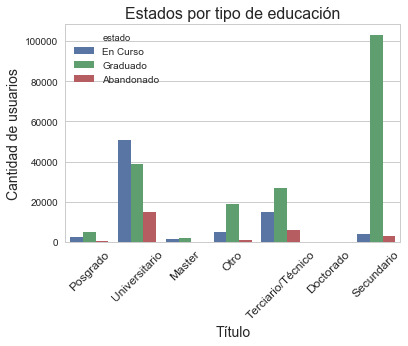

In [8]:
g = sns.countplot(x = 'nombre', hue = 'estado', data = postulantes_educacion)
g.set_title('Estados por tipo de educación', fontsize=16)
g.set_xlabel('Título', fontsize=14)
g.set_ylabel('Cantidad de usuarios', fontsize=14)
g.set_xticklabels(g.get_xticklabels(), rotation = 45, fontsize=12);

#### Postulantes_gen_y_edad

In [9]:
pos_gen_edad.head(5)

,idpostulante,fechanacimiento,sexo
0,NM5M,1970-12-03,FEM
1,5awk,1962-12-04,FEM
2,ZaO5,1978-08-10,FEM
3,NdJl,1969-05-09,MASC
4,eo2p,1981-02-16,MASC


Podemos observar que tenemos ids de los postulantes, su fecha de nacimiento y su respectivo genero.

In [10]:
pos_gen_edad.shape

(200888, 3)

In [11]:
pos_gen_edad.isnull().any()

idpostulante       False
fechanacimiento     True
sexo               False
dtype: bool

In [12]:
pos_gen_edad['sexo'].value_counts()

FEM           101981
MASC           94339
NO_DECLARA      4568
Name: sexo, dtype: int64

Podemos ver que la columna sexo tiene algunos valores nulos también, pero al estar indicados como NO_DECLARA no son detectados por `isnull`. 
Observamos que muchos de los registros que tienen fecha de nacimiento nula tampoco declaran el sexo.

In [13]:
cant_registros_vacios = len(pos_gen_edad.loc[(pos_gen_edad['fechanacimiento'].isnull()) & (pos_gen_edad['sexo'] == 'NO_DECLARA')])
cant_registros_incompletos = len(pos_gen_edad.loc[(pos_gen_edad['fechanacimiento'].isnull()) | (pos_gen_edad['sexo'] == 'NO_DECLARA')]) - cant_registros_vacios
cant_registros_totales = len(pos_gen_edad)
print('Registros vacios: {} ({:.2f} %)'.format(cant_registros_vacios, cant_registros_vacios / cant_registros_totales))
print('Registros incompletos: {} ({:.2f} %)'.format(cant_registros_incompletos, cant_registros_incompletos / cant_registros_totales))

Registros vacios: 4123 (0.02 %)
Registros incompletos: 1072 (0.01 %)


Como podemos ver, hay algunos registros vacíos y algunos registros incompletos. Ya que estos registros solamente el 0,3 % de los datos procedemos a eliminarlos.

In [14]:
pos_gen_edad = pos_gen_edad.loc[~( (pos_gen_edad['fechanacimiento'].isnull()) | (pos_gen_edad['sexo'] == 'NO_DECLARA') )]
pos_gen_edad.shape

(195693, 3)

Podemos observar que la cantidad de postulantes sobre la que se tiene esta información (195693) es mayor a la que se tiene el nivel educativo (188752) y que existen postulantes sobre los que no tenemos información de su edad o sexo.

In [15]:
pos_gen_edad['fechanacimiento'] = pd.to_datetime(pos_gen_edad['fechanacimiento'], errors = 'coerce', format= '%Y-%m-%d')
pos_gen_edad['sexo'] = pos_gen_edad['sexo'].astype('category')

In [16]:
pos_gen_edad.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195693 entries, 0 to 200886
Data columns (total 3 columns):
idpostulante       195693 non-null object
fechanacimiento    195687 non-null datetime64[ns]
sexo               195693 non-null category
dtypes: category(1), datetime64[ns](1), object(1)
memory usage: 4.7+ MB


Observamos que hay 7 registros que luego de ser convertidos a fecha dieron como resultado null. Esto puede haberse debido a que la fecha estaba en formato incorrecto u otro error. Nuevamente son muy pocos registros por lo que procederemos a eliminarlos.

In [17]:
pos_gen_edad = pos_gen_edad[~(pos_gen_edad['fechanacimiento'].isnull())]

In [18]:
pos_gen_edad.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195687 entries, 0 to 200886
Data columns (total 3 columns):
idpostulante       195687 non-null object
fechanacimiento    195687 non-null datetime64[ns]
sexo               195687 non-null category
dtypes: category(1), datetime64[ns](1), object(1)
memory usage: 4.7+ MB


In [19]:
pos_gen_edad['sexo'].value_counts()

FEM     101674
MASC     94013
Name: sexo, dtype: int64

La cantidad de datos acerca de hombres y mujeres que poseemos es aproximadamente la misma.

Agregamos una columna para la edad

In [20]:
today = date.today()
fechas = pos_gen_edad['fechanacimiento']
pos_gen_edad['edad'] = fechas.map(lambda x: today.year - x.year - ((today.month, today.day) < (x.month, x.day)))
pos_gen_edad.head(5)

,idpostulante,fechanacimiento,sexo,edad
0,NM5M,1970-12-03,FEM,47
1,5awk,1962-12-04,FEM,55
2,ZaO5,1978-08-10,FEM,39
3,NdJl,1969-05-09,MASC,48
4,eo2p,1981-02-16,MASC,37


In [21]:
print('Edad mínima:', pos_gen_edad['edad'].min())
print('Edad máxima:', pos_gen_edad['edad'].max())

Edad mínima: 12
Edad máxima: 242


In [22]:
pos_gen_edad.loc[pos_gen_edad['edad'] < 16]

,idpostulante,fechanacimiento,sexo,edad
6869,a5qWAm,2006-01-01,MASC,12


In [23]:
pos_gen_edad.loc[pos_gen_edad['edad'] > 75]

,idpostulante,fechanacimiento,sexo,edad
83825,xkppYAY,1939-07-27,MASC,78
99345,6rLd8RL,1941-09-21,MASC,76
154559,xkdvwm0,1775-07-09,MASC,242
156483,4rP8l0R,1921-08-18,FEM,96
164618,96X1loa,1917-07-08,MASC,100


Podemos ver que tenemos un registro donde la edad es 12 y algunos registros donde la edad supera la expectativa de vida. En particular vemos que uno de los registros indica 242 años, claramente indicando un error.

Optamos por no considerar estos registros

In [24]:
pos_gen_edad = pos_gen_edad.loc[~( (pos_gen_edad['edad'] < 16) | (pos_gen_edad['edad'] > 75) )]
pos_gen_edad.index = range(len(pos_gen_edad)) # Reindizar el dataframe

#### Con la limpieza terminada, procedemos a analizar la información provista en este dataframe
- Edades de los postulantes

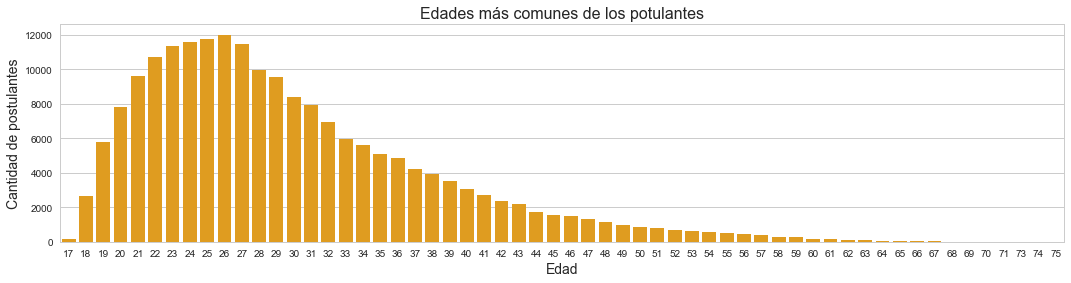

In [25]:
edades = pos_gen_edad['edad'].value_counts()
plt.figure(figsize = (18,4))
g = sns.barplot(x= edades.index, y=edades.values, orient= 'v', color = 'orange')
g.set_title('Edades más comunes de los potulantes', fontsize=16)
g.set_xlabel('Edad', fontsize=14)
g.set_ylabel('Cantidad de postulantes', fontsize=14);

Se observa que la mayor parte de los postulantes tienen entre 19 y 35 años, y que el pico se encuentra entre los 24 y 27 años.

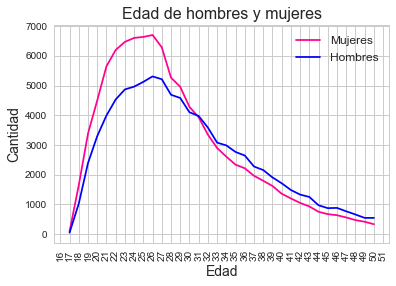

In [26]:
edades_masc = pos_gen_edad[(pos_gen_edad['sexo'] == 'MASC') & (pos_gen_edad['edad'] <= 50) ]['edad'].value_counts().sort_index()
edades_fem = pos_gen_edad[(pos_gen_edad['sexo'] == 'FEM') & (pos_gen_edad['edad'] <= 50) ]['edad'].value_counts().sort_index()
plt.figure()
edades_fem.plot(rot = 90, xticks = range(16,52), label = 'Mujeres', color='#FF0090');
edades_masc.plot(rot = 90, xticks = range(16,52), label = 'Hombres', color='blue');
plt.title('Edad de hombres y mujeres', fontsize=16)
plt.ylabel('Cantidad', fontsize=14)
plt.xlabel('Edad', fontsize=14)
plt.legend(fontsize=12);

Podemos ver también que las mujeres suelen postularse a trabajos un poco antes que los hombres, teniendo su pico entre los 22 y 26 años, mientras que los hombres lo tienen entre los 24 y 28. Observamos que hay más mujeres que hombres postulandose antes de los 30 años, y más hombres que mujeres luego de esa edad.

#### Vistas
Procedemos a analizar el dataframe de vistas

In [27]:
vistas.head(5)

,idAviso,timestamp,idpostulante
0,1111780242,2018-02-23T13:38:13.187-0500,YjVJQ6Z
1,1112263876,2018-02-23T13:38:14.296-0500,BmVpYoR
2,1112327963,2018-02-23T13:38:14.329-0500,wVkBzZd
3,1112318643,2018-02-23T13:38:17.921-0500,OqmP9pv
4,1111903673,2018-02-23T13:38:18.973-0500,DrpbXDP


In [28]:
vistas.shape

(961897, 3)

In [29]:
vistas['timestamp'] = pd.to_datetime(vistas['timestamp'], errors = 'coerce', format = "%Y-%m-%dT%H:%M:%S.%f-0500")
vistas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 961897 entries, 0 to 961896
Data columns (total 3 columns):
idAviso         961897 non-null int64
timestamp       961897 non-null datetime64[ns]
idpostulante    961897 non-null object
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 22.0+ MB


Observamos que la estructura se compone de un identificador de aviso, una marca de tiempo y un identificador de postulante. Podemos ver que tenemos alrededor de un millón de registros y que no tenemos registros vacíos.

In [30]:
print('Vista más antigua:', vistas['timestamp'].min())
print('Vista más reciente:', vistas['timestamp'].max())

Vista más antigua: 2018-02-23 13:38:10.808000
Vista más reciente: 2018-02-28 23:59:56.812000


Observamos que las vistas son tomadas solamente de la semana del 23/02/2018 al 28/02/2018 y, por consiguiente, no hay registros de vistas para un día Jueves (ya que el 23/02/2018 fue viernes y el 28/02/2018 miércoles).

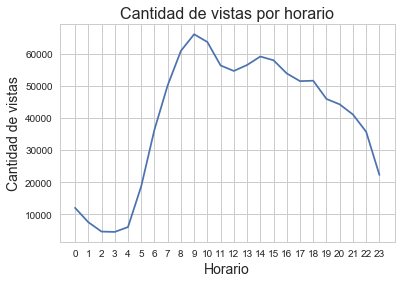

In [31]:
horarios = vistas['timestamp'].dt.hour.value_counts().sort_index()
g = horarios.plot(xticks= range(0,24))
g.set_title('Cantidad de vistas por horario', fontsize=16)
g.set_xlabel('Horario', fontsize=14)
g.set_ylabel('Cantidad de vistas', fontsize=14);

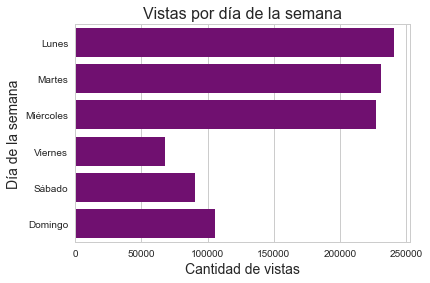

In [32]:
dia_de_semana = {0: 'Lunes', 1: 'Martes', 2: 'Miércoles', 3: 'Jueves', 4: 'Viernes', 5: 'Sábado', 6: 'Domingo'}
weekdays = vistas['timestamp'].dt.weekday.value_counts().sort_index()
g = sns.barplot(x=weekdays.values, y=weekdays.index.map(lambda x: dia_de_semana[x]), orient ='h', color = 'purple')
g.set_title('Vistas por día de la semana', fontsize=16)
g.set_xlabel('Cantidad de vistas', fontsize=14)
g.set_ylabel('Día de la semana', fontsize=14);

#### Postulaciones
Procedemos a ver cómo está conformado el dataframe de postulaciones y a realizar las limpiezas necesarias.

In [33]:
postulaciones.head(5)

,idaviso,idpostulante,fechapostulacion
0,1112257047,NM5M,2018-01-15 16:22:34
1,1111920714,NM5M,2018-02-06 09:04:50
2,1112346945,NM5M,2018-02-22 09:04:47
3,1112345547,NM5M,2018-02-22 09:04:59
4,1112237522,5awk,2018-01-25 18:55:03


In [34]:
postulaciones.shape

(3401623, 3)

In [35]:
postulaciones['fechapostulacion'] = pd.to_datetime(postulaciones['fechapostulacion'],errors = 'coerce', format = "%Y-%m-%d %H:%M:%S")

In [36]:
postulaciones.isnull().any()

idaviso             False
idpostulante        False
fechapostulacion    False
dtype: bool

In [37]:
postulaciones.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3401623 entries, 0 to 3401622
Data columns (total 3 columns):
idaviso             int64
idpostulante        object
fechapostulacion    datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 77.9+ MB


In [38]:
print('Postulación más antigua:', postulaciones['fechapostulacion'].min())
print('Postulación más reciente:', postulaciones['fechapostulacion'].max())

Postulación más antigua: 2018-01-15 00:00:01
Postulación más reciente: 2018-02-28 23:59:55


Observamos que la estructura se compone de un id de postulante, un id de aviso y una marca de tiempo y que no hay registros nulos/inválidos.

Notamos que los datos que tenemos sobre visualizaciones de avisos son del día 23/02/2018 al 28/02/2018 mientras que los datos sobre postulaciones son en un rango más amplio de fechas, empezando el 15/01/2018 y finalizando el 28/02/2018. Esto significa que las comparaciones entre estos dataframes sólo se podrán hacer recortando el de postulaciones al rango de fechas del de vistas.

Para poder comparar entre vistas y postulaciones separamos las postulaciones de dicha semana.

In [39]:
postulaciones_ult_semana_febrero = \
    postulaciones.loc[(postulaciones['fechapostulacion'] >= '2018-02-23') & (postulaciones['fechapostulacion'] <= '2018-02-28')]

#### Analizamos a cuantos avisos se postularon los usuarios.

In [40]:
postulantes = postulaciones['idpostulante'].value_counts()
postulantes.describe()

count    200888.000000
mean         16.932933
std          31.267385
min           1.000000
25%           3.000000
50%           8.000000
75%          19.000000
max        3166.000000
Name: idpostulante, dtype: float64

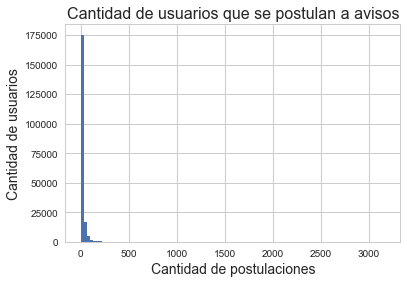

In [41]:
g = postulantes.hist(bins=100)
g.set_title('Cantidad de usuarios que se postulan a avisos', fontsize=16)
g.set_xlabel('Cantidad de postulaciones', fontsize=14)
g.set_ylabel('Cantidad de usuarios', fontsize=14);

Filtramos porque como vemos muy pocos usuarios se han postulado a muchisimos avisos.

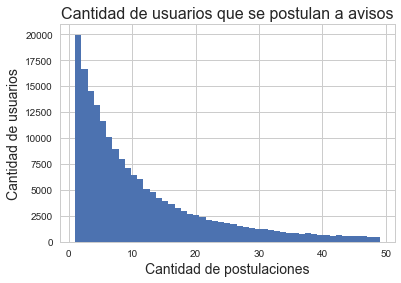

In [42]:
postulantes_filt = postulantes[postulantes.values < 50]
g = postulantes_filt.hist(bins=49)
g.set_title('Cantidad de usuarios que se postulan a avisos', fontsize=16)
g.set_xlabel('Cantidad de postulaciones', fontsize=14)
g.set_ylabel('Cantidad de usuarios', fontsize=14);

Observamos cuantas postulaciones recibieron los avisos

In [43]:
pos_por_aviso = postulaciones['idaviso'].value_counts()
pos_por_aviso.describe()

count    12692.000000
mean       268.013158
std        542.269598
min          1.000000
25%         33.000000
50%        100.000000
75%        269.250000
max       9932.000000
Name: idaviso, dtype: float64

De acá obtenemos que un aviso recibe en promedio 268 postulaciones, habiendo avisos que solamente recibieron una postulación y avisos que recibieron más de 9000 postulaciones. Observamos que el desvío estándar es bastante alto, mostrando que hay mucha variación en la cantidad de postulaciones que cada aviso recibe.

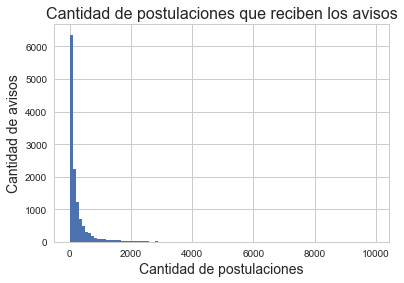

In [44]:
g = pos_por_aviso.hist(bins=100)
g.set_title('Cantidad de postulaciones que reciben los avisos', fontsize=16)
g.set_xlabel('Cantidad de postulaciones', fontsize=14)
g.set_ylabel('Cantidad de avisos', fontsize=14);

De igual manera, muy poca cantidad de avisos reciben varios miles de postulaciones más que el resto.

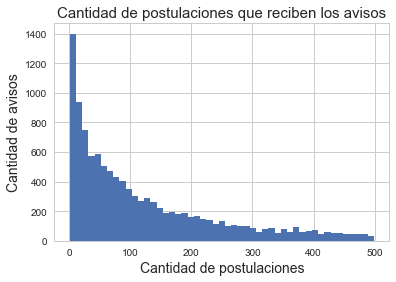

In [45]:
pos_por_aviso_filt = pos_por_aviso[pos_por_aviso.values < 500]
g = pos_por_aviso_filt.hist(bins=49)
g.set_title('Cantidad de postulaciones que reciben los avisos', fontsize=15)
g.set_xlabel('Cantidad de postulaciones', fontsize=14)
g.set_ylabel('Cantidad de avisos', fontsize=14);

#### Procedemos a analizar en qué horarios la gente suele postularse a los avisos

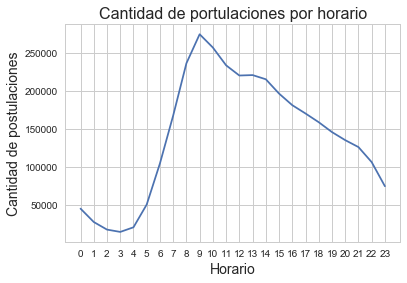

In [46]:
horarios = postulaciones['fechapostulacion'].dt.hour.value_counts().sort_index()
g = horarios.plot(xticks= range(0,24))
g.set_title('Cantidad de portulaciones por horario', fontsize=16)
g.set_xlabel('Horario', fontsize=14)
g.set_ylabel('Cantidad de postulaciones', fontsize=14);

Observamos que el horario pico de postulaciones es entre las 8 y las 11 de la mañana.

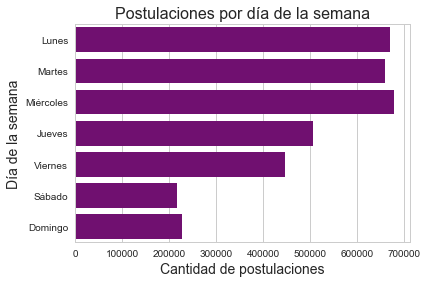

In [47]:
dia_de_semana = {0: 'Lunes', 1: 'Martes', 2: 'Miércoles', 3: 'Jueves', 4: 'Viernes', 5: 'Sábado', 6: 'Domingo'}
weekdays = postulaciones['fechapostulacion'].dt.weekday.value_counts().sort_index()
g = sns.barplot(x=weekdays.values, y=weekdays.index.map(lambda x: dia_de_semana[x]), orient ='h', color = 'purple')
g.set_title('Postulaciones por día de la semana', fontsize=16)
g.set_xlabel('Cantidad de postulaciones', fontsize=14)
g.set_ylabel('Día de la semana', fontsize=14);

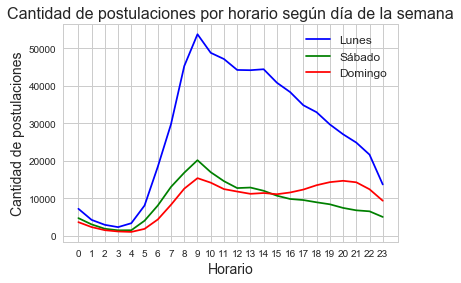

In [48]:
lunes = (postulaciones['fechapostulacion'].dt.weekday.values == 0)
sabados = (postulaciones['fechapostulacion'].dt.weekday.values == 5)
domingos = (postulaciones['fechapostulacion'].dt.weekday.values == 6)
horarios_lunes = (postulaciones[lunes])['fechapostulacion'].dt.hour.value_counts().sort_index()
horarios_sabados = (postulaciones[sabados])['fechapostulacion'].dt.hour.value_counts().sort_index()
horarios_domingos = (postulaciones[domingos])['fechapostulacion'].dt.hour.value_counts().sort_index()
g_lun = horarios_lunes.plot(xticks= range(0,24), color='b')
g_sab = horarios_sabados.plot(xticks= range(0,24), color='g')
g = horarios_domingos.plot(xticks= range(0,24), color='r')
g.set_title('Cantidad de postulaciones por horario según día de la semana', fontsize=16)
g.set_xlabel('Horario', fontsize=14)
g.set_ylabel('Cantidad de postulaciones', fontsize=14);
g.legend(['Lunes', 'Sábado', 'Domingo'], fontsize=12);

Se observa que la cantidad de postulaciones de los días lunes es muy superior a la de los fines de semana. También podemos ver que los sábados mantienen el mismo patrón de horarios que los lunes, pero que los domingos esto cambia, incrementando la cantidad de postulaciones al final del día

In [49]:
weekdays = postulaciones['fechapostulacion'].dt.weekday
lunes = (weekdays.values == 0)
martes = (weekdays.values == 1)
miercoles = (weekdays.values == 2)
jueves = (weekdays.values == 3)
viernes = (weekdays.values == 4)
sabados = (weekdays.values == 5)
domingos = (weekdays.values == 6)

horarios_lunes = (postulaciones[lunes])['fechapostulacion'].dt.hour.value_counts().sort_index()
horarios_martes = (postulaciones[martes])['fechapostulacion'].dt.hour.value_counts().sort_index()
horarios_miercoles = (postulaciones[miercoles])['fechapostulacion'].dt.hour.value_counts().sort_index()
horarios_jueves = (postulaciones[jueves])['fechapostulacion'].dt.hour.value_counts().sort_index()
horarios_viernes = (postulaciones[viernes])['fechapostulacion'].dt.hour.value_counts().sort_index()
horarios_sabados = (postulaciones[sabados])['fechapostulacion'].dt.hour.value_counts().sort_index()
horarios_domingos = (postulaciones[domingos])['fechapostulacion'].dt.hour.value_counts().sort_index()

dias_vs_horarios = {'lunes': horarios_lunes, 'martes': horarios_martes, 'miercoles': horarios_miercoles,\
                   'jueves': horarios_jueves, 'viernes': horarios_viernes,'sabados': horarios_sabados,\
                   'domingos': horarios_domingos}
dias_vs_horas = pd.DataFrame(data = dias_vs_horarios)
dias_vs_horas = dias_vs_horas[['lunes','martes','miercoles','jueves','viernes','sabados','domingos']]

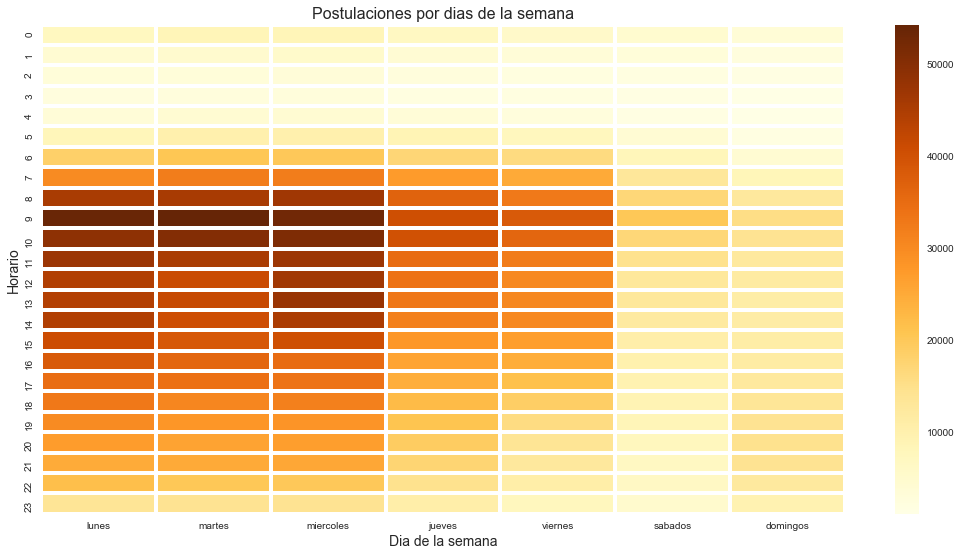

In [50]:
plt.figure(figsize = (18,9))
ax = sns.heatmap(dias_vs_horas,linewidth = 3,cmap="YlOrBr")
ax.set_title('Postulaciones por dias de la semana',Fontsize = 16)
ax.set_xlabel('Dia de la semana',Fontsize = 14)
ax.set_ylabel('Horario',fontsize = 14);

Se puede ver que los dias de la semana con mayor cantidad de postulaciones son los dias laborales mientras que los sabados y domingos cae la cantidad de postulaciones

#### avisos_detalle

In [51]:
avisos_detalle.head(5)

,idaviso,idpais,titulo,descripcion,nombre_zona,ciudad,mapacalle,tipo_de_trabajo,nivel_laboral,nombre_area,denominacion_empresa
0,8725750,1,VENDEDOR/A PROVINCIA DE SANTA FE,<p><strong><strong>Empresa:</strong></strong> ...,Gran Buenos Aires,NaN,NaN,Full-time,Senior / Semi-Senior,Comercial,VENTOR
1,17903700,1,Enfermeras,<p>Solicitamos para importante cadena de farma...,Gran Buenos Aires,NaN,NaN,Full-time,Senior / Semi-Senior,Salud,Farmacias Central Oeste
2,1000150677,1,Chofer de taxi,<p>TE GUSTA MANEJAR? QUERES GANAR PLATA HACIEN...,Capital Federal,NaN,Empedrado 2336,Full-time,Senior / Semi-Senior,Transporte,FAMITAX SRL
3,1000610287,1,CHOFER DE CAMIONETA BAHIA BLANCA - PUNTA ALTA,<p><strong>Somos una empresa multinacional que...,Gran Buenos Aires,NaN,NaN,Full-time,Senior / Semi-Senior,Transporte,Wurth Argentina S.A
4,1000872556,1,Operarios de Planta - Rubro Electrodomésticos,<p><strong>OPERARIOS DE PLANTA</strong></p><p>...,Gran Buenos Aires,NaN,NaN,Full-time,Senior / Semi-Senior,Producción,ELECTRO OUTLET SRL


In [52]:
avisos_detalle.shape

(13534, 11)

In [53]:
avisos_detalle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13534 entries, 0 to 13533
Data columns (total 11 columns):
idaviso                 13534 non-null int64
idpais                  13534 non-null int64
titulo                  13534 non-null object
descripcion             13534 non-null object
nombre_zona             13534 non-null object
ciudad                  47 non-null object
mapacalle               872 non-null object
tipo_de_trabajo         13534 non-null object
nivel_laboral           13534 non-null object
nombre_area             13534 non-null object
denominacion_empresa    13529 non-null object
dtypes: int64(2), object(9)
memory usage: 1.1+ MB


In [54]:
avisos_detalle["nombre_zona"].value_counts()

Gran Buenos Aires              12654
Capital Federal                  876
Buenos Aires (fuera de GBA)        2
GBA Oeste                          2
Name: nombre_zona, dtype: int64

Observamos que la estructura se compone de un id de aviso e información sobre el mismo. Sin embargo, notamos que sólo las columnas "nombre_zona", "tipo_trabajo", "nivel_laboral", "nombre_area" y "denominacion_empresa" nos aportan información que podamos analizar. Las columnas "mapacalle" y "ciudad" sólo están completas en unos pocos registros y las columnas "descripcion" y "titulo" no poseen información que podamos clasificar.

Podemos ver también que la mayor cantidad de trabajos se encuentran en Gran Buenos Aires.

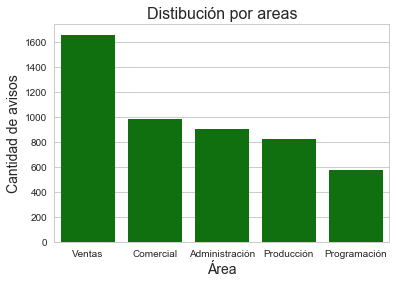

In [55]:
avisos_por_area = avisos_detalle["nombre_area"].value_counts().head(5)
g = sns.barplot(y=avisos_por_area.values, x=avisos_por_area.index, orient='v',color = 'g')
g.set_title('Distibución por areas', fontsize=16)
g.set_xlabel('Área', fontsize=14)
g.set_ylabel('Cantidad de avisos', fontsize=14);

In [56]:
avisos_detalle["denominacion_empresa"].value_counts().describe()

count    2592.000000
mean        5.219522
std        22.328432
min         1.000000
25%         1.000000
50%         1.000000
75%         3.000000
max       562.000000
Name: denominacion_empresa, dtype: float64

Observamos que la mayoria de las empresas tiene pocos avisos, mientras que unas pocas son las que tienen gran cantidad de avisos.

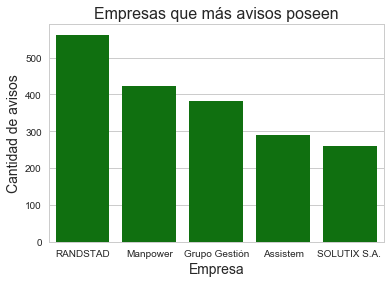

In [57]:
top_5= avisos_detalle["denominacion_empresa"].value_counts()[:5]
g = sns.barplot(x=top_5.index, y = top_5.values, orient = 'v', color = 'g')
g.set_title('Empresas que más avisos poseen', fontsize=16)
g.set_xlabel('Empresa', fontsize=14)
g.set_ylabel('Cantidad de avisos', fontsize=14);

https://www.randstad.com.ar/
https://www.manpowergroup.com.ar/
https://www.grupo-gestion.com.ar/
http://www.assistem.com.ar/
http://www.solutix.com.ar/

Detalle bastante peculiar, las empresas que tienen más avisos publicados son justamente empresas que se encargan de las mismas tareas que zonaJobs, enlazar personas con empresas en busca de trabajo. Esto parecería indicar que el mayor caudal de avisos son republicaciones de otras páginas.

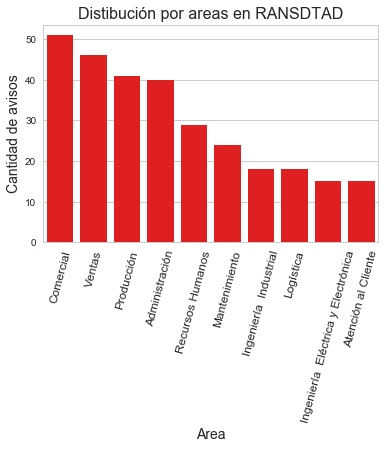

In [58]:
empleos = avisos_detalle[avisos_detalle['denominacion_empresa'] == "RANDSTAD"]['nombre_area'].value_counts()[:10]
g = sns.barplot(x=empleos.index, y = empleos.values, orient = 'v', color = 'r')
g.set_title('Distibución por areas en RANSDTAD', fontsize=16)
g.set_xlabel('Area', fontsize=14)
g.set_ylabel('Cantidad de avisos', fontsize=14)
g.set_xticklabels(g.get_xticklabels(), rotation = 75, fontsize=12);

Como vemos, los avisos de Randstad son en areas bastante variadas, lo cual nos hace pensar que si es posible que sus avisos sean republicados en zonaJobs.

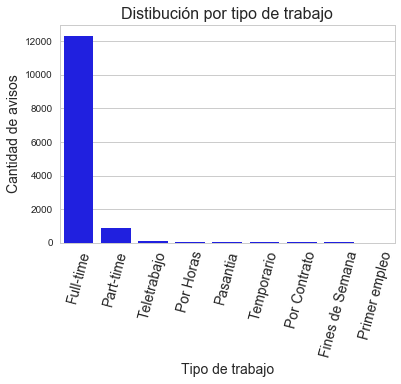

In [59]:
tipo_de_trabajo = avisos_detalle["tipo_de_trabajo"].value_counts()
g = sns.barplot(x=tipo_de_trabajo.index, y = tipo_de_trabajo.values, orient = 'v', color = 'b')
g.set_title('Distibución por tipo de trabajo', fontsize=16)
g.set_xlabel('Tipo de trabajo', fontsize=14)
g.set_ylabel('Cantidad de avisos', fontsize=14)
g.set_xticklabels(g.get_xticklabels(), rotation = 75, fontsize=14);

In [60]:
tipo_de_trabajo

Full-time          12339
Part-time            863
Teletrabajo          110
Por Horas             63
Pasantia              63
Temporario            42
Por Contrato          37
Fines de Semana       14
Primer empleo          3
Name: tipo_de_trabajo, dtype: int64

Podemos ver que casi todos los trabajos son full-time.

In [61]:
avisos_detalle["nivel_laboral"].value_counts()

Senior / Semi-Senior                    9407
Junior                                  2216
Otro                                     921
Jefe / Supervisor / Responsable          809
Gerencia / Alta Gerencia / Dirección     181
Name: nivel_laboral, dtype: int64

Aunque los datos de nivel laboral no son muy precisos ya que aparentemente es un campo obligatorio a la hora de generar un aviso y por eso encontramos caso como Chofer de taxi Senior cuando no tiene ningun sentido.

### Edad vs nivel educativo
Analizamos el nivel educativo de los postulantes según su edad

In [62]:
postulantes_graduados = postulantes_educacion[postulantes_educacion['estado'] == 'Graduado']
postulantes_graduados = pd.crosstab(postulantes_graduados.idpostulante, postulantes_graduados.nombre)
postulantes_graduados.head()

nombre,Doctorado,Master,Otro,Posgrado,Secundario,Terciario/Técnico,Universitario
idpostulante,,,,,,,
0z5VvGv,0,0,0,0,1,0,0
0zB026d,0,0,0,0,1,1,0
0zB03O9,0,0,0,0,1,0,0
0zB08lq,0,0,0,0,1,0,0
0zB0NWY,0,0,0,0,0,0,1


In [63]:
postulantes_graduados = postulantes_graduados.reset_index()

In [64]:
postulantes_graduados_edad = pd.merge(postulantes_graduados, pos_gen_edad[['idpostulante','edad']], on='idpostulante', how='inner')
postulantes_graduados_edad.head()

,idpostulante,Doctorado,Master,Otro,Posgrado,Secundario,Terciario/Técnico,Universitario,edad
0,0z5VvGv,0,0,0,0,1,0,0,30
1,0zB026d,0,0,0,0,1,1,0,40
2,0zB03O9,0,0,0,0,1,0,0,30
3,0zB08lq,0,0,0,0,1,0,0,45
4,0zB0NWY,0,0,0,0,0,0,1,30


In [65]:
graduados_por_edad = postulantes_graduados_edad.groupby('edad').aggregate(sum)
graduados_por_edad.head()

,Doctorado,Master,Otro,Posgrado,Secundario,Terciario/Técnico,Universitario
edad,,,,,,,
17,0,0,3,0,68,1,1
18,0,0,102,5,1676,54,6
19,1,7,322,5,3778,197,26
20,4,4,551,21,5187,345,48
21,0,10,817,34,6376,673,160


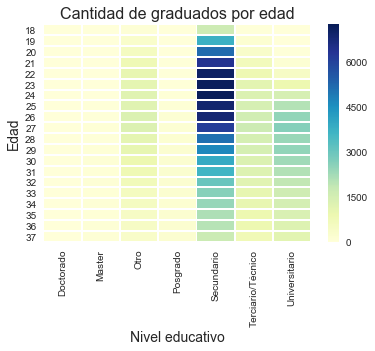

In [66]:
g = sns.heatmap(graduados_por_edad[1:21], cmap="YlGnBu", linewidths = 1)
g.set_title('Cantidad de graduados por edad', fontsize=16)
g.set_xlabel('Nivel educativo', fontsize=14);
g.set_ylabel('Edad', fontsize=14);


Repetimos el proceso para los que estan en curso.

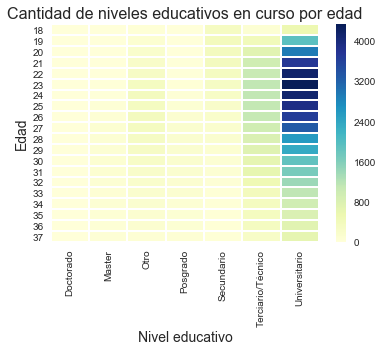

In [67]:
postulantes_en_curso = postulantes_educacion[postulantes_educacion['estado'] == 'En Curso']
postulantes_en_curso = pd.crosstab(postulantes_en_curso.idpostulante, postulantes_en_curso.nombre)
postulantes_en_curso = postulantes_en_curso.reset_index()
postulantes_en_curso_edad = pd.merge(postulantes_en_curso, pos_gen_edad[['idpostulante','edad']], on='idpostulante', how='inner')
en_curso_por_edad = postulantes_en_curso_edad.groupby('edad').aggregate(sum)
g = sns.heatmap(en_curso_por_edad[1:21], cmap="YlGnBu", linewidths = 1)
g.set_title('Cantidad de niveles educativos en curso por edad', fontsize = 16)
g.set_xlabel('Nivel educativo', fontsize=14);
g.set_ylabel('Edad', fontsize=14);

Hagamos un analisís aparte para solo Universitarios, un nivel educativo muy importante en el ambito laboral

In [68]:
postulantes_universitarios = postulantes_educacion[postulantes_educacion['nombre'] == 'Universitario']
postulantes_universitarios = pd.crosstab(postulantes_universitarios.idpostulante, postulantes_universitarios.estado)
postulantes_universitarios = postulantes_universitarios.reset_index()
postulantes_universitarios = pd.merge(postulantes_universitarios, pos_gen_edad[['idpostulante','edad']], on='idpostulante', how='inner')
universitarios_por_edad = postulantes_universitarios.groupby('edad').aggregate(sum)
universitarios_por_edad.head()


,Abandonado,En Curso,Graduado
edad,,,
17,0,18,1
18,18,535,6
19,90,1929,26
20,225,2933,48
21,384,3750,160


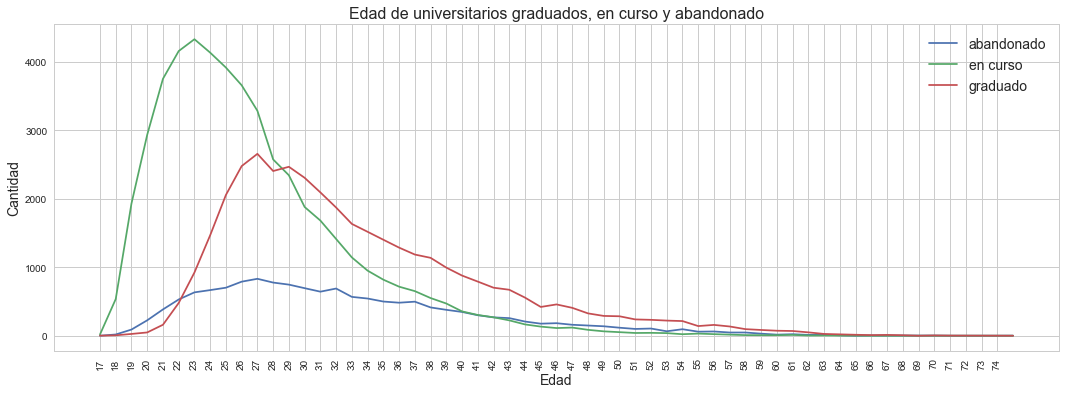

In [69]:
edades_abandonado = universitarios_por_edad['Abandonado']
edades_en_curso = universitarios_por_edad['En Curso']
edades_graduados = universitarios_por_edad['Graduado']
plt.figure(figsize = (18, 6))
edades_abandonado.plot(rot = 90, xticks = range(17,75), label = 'abandonado');
edades_en_curso.plot(rot = 90, xticks = range(17,75), label = 'en curso');
edades_graduados.plot(rot = 90, xticks = range(17,75), label = 'graduado');
plt.title('Edad de universitarios graduados, en curso y abandonado', fontsize = 16)
plt.ylabel('Cantidad',fontsize=14)
plt.xlabel('Edad', fontsize=14)
plt.legend(fontsize = 14);

Agregamos el sexo a este análisis

In [70]:
def nombre_to_num(nombre):
    dicc = {'Doctorado': 1,'Master':2, 'Otro':3, 'Posgrado':4, 'Secundario':5, 'Terciario/Técnico':6, 'Universitario':7}
    return dicc[nombre]

In [71]:
postulantes_en_curso = postulantes_educacion[postulantes_educacion['estado'] == 'En Curso']

In [72]:
postulantes_en_curso_edad_sexo = pd.merge(postulantes_en_curso[['idpostulante','nombre']], pos_gen_edad[['idpostulante','edad','sexo']], on='idpostulante', how='inner')
postulantes_en_curso_edad_sexo.head()

,idpostulante,nombre,edad,sexo
0,NdJl,Posgrado,48,MASC
1,8BkL,Universitario,41,FEM
2,1d2B,Universitario,42,MASC
3,NPBx,Universitario,37,MASC
4,NPBx,Master,37,MASC


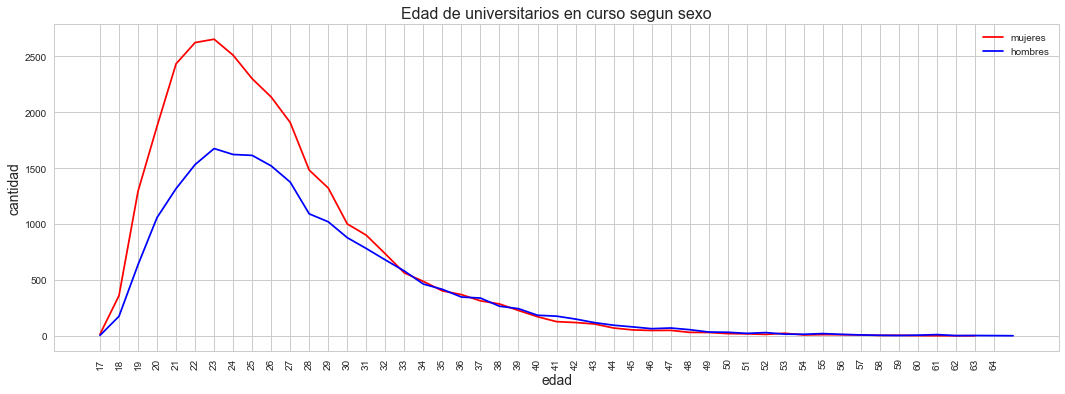

In [73]:
mujeres = postulantes_en_curso_edad_sexo[\
            postulantes_en_curso_edad_sexo['sexo'] == 'FEM']
hombres = postulantes_en_curso_edad_sexo[\
            postulantes_en_curso_edad_sexo['sexo'] == 'MASC']
mujeres_universitarias = mujeres[mujeres['nombre'] == 'Universitario']
hombres_universitarios = hombres[hombres['nombre'] == 'Universitario']
edades_mujeres_universitarias = mujeres_universitarias['edad'].value_counts().sort_index()
edades_hombres_universitarios = hombres_universitarios['edad'].value_counts().sort_index()
plt.figure(figsize=(18,6))
f = edades_mujeres_universitarias.plot(rot = 90, xticks = range(17,65), label = 'mujeres', color='r');
f = edades_hombres_universitarios.plot(rot = 90, xticks = range(17,65), label = 'hombres', color = 'b');
plt.title('Edad de universitarios en curso segun sexo', fontsize = 16)
f.set_xlabel('edad', fontsize = 14)
f.set_ylabel('cantidad', fontsize = 14)
plt.legend();

#### Sexo de los postulantes segun el area

In [74]:
postulaciones_area = pd.merge(postulaciones, pd.DataFrame(avisos_detalle[['idaviso', 'nombre_area', 'nivel_laboral', 'tipo_de_trabajo']]), on='idaviso', how='left')
postulaciones_area_uf = pd.merge(postulaciones_ult_semana_febrero, pd.DataFrame(avisos_detalle[['idaviso', 'nombre_area', 'nivel_laboral', 'tipo_de_trabajo']]), on='idaviso', how='left')
postulaciones_area.head()

,idaviso,idpostulante,fechapostulacion,nombre_area,nivel_laboral,tipo_de_trabajo
0,1112257047,NM5M,2018-01-15 16:22:34,Atención al Cliente,Otro,Part-time
1,1111920714,NM5M,2018-02-06 09:04:50,Telemarketing,Senior / Semi-Senior,Part-time
2,1112346945,NM5M,2018-02-22 09:04:47,Telemarketing,Senior / Semi-Senior,Full-time
3,1112345547,NM5M,2018-02-22 09:04:59,Telemarketing,Senior / Semi-Senior,Full-time
4,1112237522,5awk,2018-01-25 18:55:03,Contabilidad,Senior / Semi-Senior,Full-time


In [75]:
postulaciones_area.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3401623 entries, 0 to 3401622
Data columns (total 6 columns):
idaviso             int64
idpostulante        object
fechapostulacion    datetime64[ns]
nombre_area         object
nivel_laboral       object
tipo_de_trabajo     object
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 181.7+ MB


Utilizamos avisos_online

In [76]:
avisos_online.head(5)

,idaviso
0,1112355872
1,1112335374
2,1112374842
3,1111984070
4,1111822480


In [77]:
avisos_online.shape

(5028, 1)

Aquí podemos ver los avisos online al 8 de marzo de 2018

In [78]:
#Se filtran avisos quedandonos solo con las publicaciones online
postulaciones_area_online = pd.merge(postulaciones_area, avisos_online, on='idaviso', how='inner')
postulaciones_area_online_uf = pd.merge(postulaciones_area, avisos_online, on='idaviso', how='inner')

In [79]:
#Mas de la mitad de las postulaciones son de ofertas laborales viejas que estan offline
postulaciones_area_online.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1345820 entries, 0 to 1345819
Data columns (total 6 columns):
idaviso             1345820 non-null int64
idpostulante        1345820 non-null object
fechapostulacion    1345820 non-null datetime64[ns]
nombre_area         1246308 non-null object
nivel_laboral       1246308 non-null object
tipo_de_trabajo     1246308 non-null object
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 71.9+ MB


In [80]:
postulaciones_area_online = pd.merge(postulaciones_area_online, pos_gen_edad, on='idpostulante', how='left')
postulaciones_area_online_uf = pd.merge(postulaciones_area_online_uf, pos_gen_edad, on='idpostulante', how='left')
postulaciones_area_online.head()

,idaviso,idpostulante,fechapostulacion,nombre_area,nivel_laboral,tipo_de_trabajo,fechanacimiento,sexo,edad
0,1112346945,NM5M,2018-02-22 09:04:47,Telemarketing,Senior / Semi-Senior,Full-time,1970-12-03,FEM,47.0
1,1112346945,EeEaXo,2018-02-19 21:58:42,Telemarketing,Senior / Semi-Senior,Full-time,1984-03-23,FEM,34.0
2,1112346945,ZR0rWY,2018-02-20 09:38:14,Telemarketing,Senior / Semi-Senior,Full-time,1989-04-04,MASC,29.0
3,1112346945,6OWl1v,2018-02-27 22:59:31,Telemarketing,Senior / Semi-Senior,Full-time,1971-10-23,FEM,46.0
4,1112346945,E2Y16b,2018-02-20 05:27:05,Telemarketing,Senior / Semi-Senior,Full-time,1967-03-18,FEM,51.0


In [81]:
postulaciones_area_online['nombre_area'].value_counts().head(10)

Ventas                 173051
Administración         120008
Producción             111104
Comercial               94609
Atención al Cliente     76103
Call Center             57731
Recepcionista           48999
Tesorería               34890
Telemarketing           34218
Contabilidad            22461
Name: nombre_area, dtype: int64

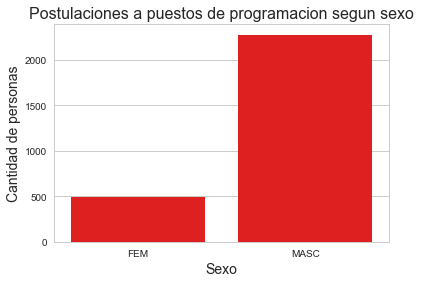

In [82]:
plot_data = postulaciones_area_online.loc[postulaciones_area_online['nombre_area'] == 'Programación']['sexo'].value_counts()
g = sns.barplot(y=plot_data.values, x=plot_data.index, color='r')
g.set_title('Postulaciones a puestos de programacion segun sexo', fontsize = 16)
g.set_xlabel('Sexo', fontsize = 14)
g.set_ylabel('Cantidad de personas', fontsize = 14);

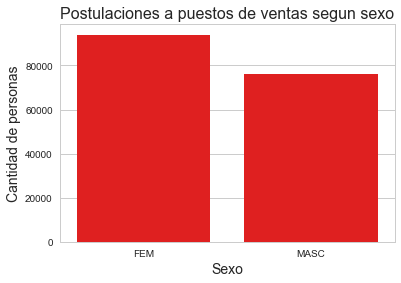

In [83]:
plot_data = postulaciones_area_online.loc[postulaciones_area_online['nombre_area'] == 'Ventas']['sexo'].value_counts()
g = sns.barplot(y=plot_data.values, x=plot_data.index, color='r')
g.set_title('Postulaciones a puestos de ventas segun sexo', fontsize = 16)
g.set_xlabel('Sexo', fontsize = 14)
g.set_ylabel('Cantidad de personas', fontsize = 14);

Hacemos un análisis sobre la edad de los postulantes en distintas áreas

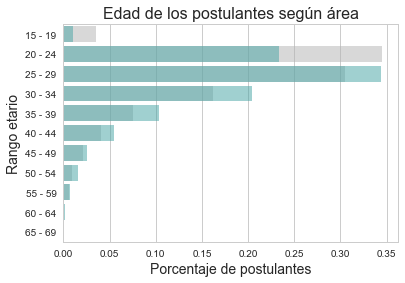

In [84]:
postulaciones_area_online['edad'] = 2018 - postulaciones_area_online['fechanacimiento'].dt.year
postulaciones_area_online['rangoetario'] = pd.cut(postulaciones_area_online['edad'], range(15, 71, 5), right=False, labels=['{} - {}'.format(i, i + 4) for i in range(15, 70, 5)])
plot_data = postulaciones_area_online.loc[postulaciones_area_online['nombre_area'] == 'Ventas']['rangoetario'].value_counts(normalize=True)
g_1 = sns.barplot(x=plot_data.values, y=plot_data.index, color=(0.7, 0.7, 0.7), orient='h', alpha=0.5)
plot_data = postulaciones_area_online.loc[postulaciones_area_online['nombre_area'] == 'Administración']['rangoetario'].value_counts(normalize=True)
g = sns.barplot(x=plot_data.values, y=plot_data.index, color=(0.2, 0.7, 0.7), orient='h', alpha=0.5)
g.set_ylabel('Rango etario', fontsize = 14)
g.set_xlabel('Porcentaje de postulantes', fontsize = 14)
g.set_title('Edad de los postulantes según área', fontsize = 16);

En este ultimo gráfico podemos observar que la edad más común para postularse a un empleo en el área de ventas es entre los 20 y 24 años, mientras que en administración la edad más común es entre 25 y 29 años.

Aclaración: Las barras grises corresponden a el área "Ventas" y las azules a "Administración".

Analizamos cuales son los anuncios que los usuarios visitan

In [85]:
detalle_visitas = pd.DataFrame({"idAviso":avisos_detalle["idaviso"].values,
    "nombre_area":avisos_detalle["nombre_area"].values,
   "denominacion_empresa":avisos_detalle["denominacion_empresa"].values})
detalle_visitas = pd.merge(vistas, detalle_visitas, on='idAviso', how='left')
detalle_visitas.head()

,idAviso,timestamp,idpostulante,denominacion_empresa,nombre_area
0,1111780242,2018-02-23 13:38:13.187,YjVJQ6Z,dm,Programación de producción
1,1112263876,2018-02-23 13:38:14.296,BmVpYoR,Stefanini Argentina SRL,Infraestructura
2,1112327963,2018-02-23 13:38:14.329,wVkBzZd,Adecco -Región Office,Community Management
3,1112318643,2018-02-23 13:38:17.921,OqmP9pv,Prosegur S.A.,Administración
4,1111903673,2018-02-23 13:38:18.973,DrpbXDP,Farmacias Central Oeste,Farmacéutica


In [86]:
detalle_visitas["denominacion_empresa"].value_counts().head()

Manpower                 35693
RANDSTAD                 30616
Assistem                 25653
Adecco -Región Office    24139
Grupo Gestión            21395
Name: denominacion_empresa, dtype: int64

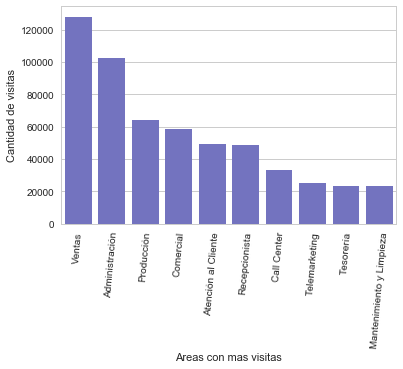

In [87]:
data = detalle_visitas["nombre_area"].value_counts().head(10)
g = sns.barplot(x=data.index, y = data.values, orient = 'v', color = (0.4, 0.4, 0.8))
g.set_xlabel('Areas con mas visitas')
g.set_ylabel('Cantidad de visitas')
g.set_xticklabels(g.get_xticklabels(), rotation = 85);

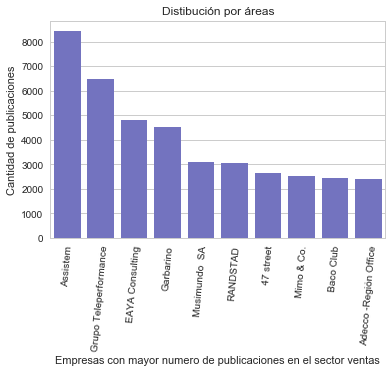

In [88]:
top_sector_ventas=detalle_visitas.loc[detalle_visitas['nombre_area'] == 'Ventas']["denominacion_empresa"].value_counts()[:10]
g = sns.barplot(x=top_sector_ventas.index, y = top_sector_ventas.values, orient = 'v', color=(0.4,0.4,0.8))
g.set_title('Distibución por áreas')
g.set_xlabel('Empresas con mayor numero de publicaciones en el sector ventas')
g.set_ylabel('Cantidad de publicaciones')
g.set_xticklabels(g.get_xticklabels(), rotation = 85);

Comparando con el gráfico de publicaciones por áreas de trabajo podemos ver que a pesar de que las primeras
categorías visitadas coinciden con las categorías más publicaciones, concluyendo que hay una buena relación de 
proporción entre la oferta y la demanda (considerando a la demanda como la cantidad de visitas) pero a partir
del puesto número 5 vemos que empiezan a no coincidir mostrando que hay una parte considerable de la demanda 
que no está siendo atendida.

Analizamos a qué áreas se postulan los usuarios

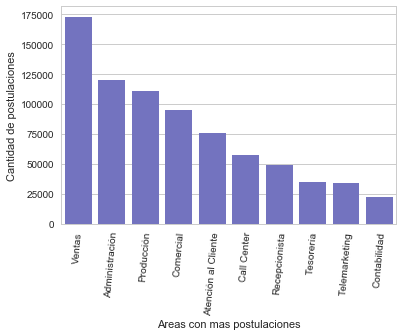

In [89]:
data = postulaciones_area_online["nombre_area"].value_counts().head(10)
g = sns.barplot(x=data.index, y = data.values, orient = 'v', color = (0.4, 0.4, 0.8))
g.set_xlabel('Areas con mas postulaciones')
g.set_ylabel('Cantidad de postulaciones')
g.set_xticklabels(g.get_xticklabels(), rotation = 85);

Comparamos visitas vs postulaciones

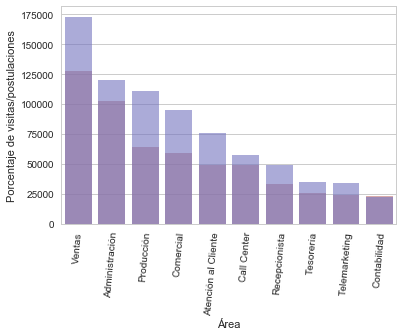

In [90]:
data_postulaciones = postulaciones_area_online_uf["nombre_area"].value_counts(normalize=False).head(10)
data_vistas = detalle_visitas["nombre_area"].value_counts(normalize=False).head(10)
g = sns.barplot(x=data_vistas.index, y = data_vistas.values, orient = 'v', color = (0.8, 0.4, 0.4), alpha=0.6)
g = sns.barplot(x=data_postulaciones.index, y = data_postulaciones.values, orient = 'v', color = (0.4, 0.4, 0.8), alpha=0.6)
g.set_xlabel('Área')
g.set_ylabel('Porcentaje de visitas/postulaciones')
g.set_xticklabels(g.get_xticklabels(), rotation = 85);

Podemos ver que un poco más de la mitad de las visitas se convierten en postulaciones.